https://python.langchain.com/docs/tutorials/rag/

由LLM支持的最强大的应用之一是复杂的问答（Q&A）聊天机器人。这些应用程序能够回答关于特定源信息的问题，它们使用了一种被称为检索增强生成（Retrieval Augmented Generation, RAG）的技术。  
  
这个教程分为多个部分：  

第一部分（本指南） 介绍RAG并 walkthrough 一个最小实现。  
第二部分 扩展实现以适应对话风格的交互和多步骤检索过程。  

本教程将展示如何在文本数据源上构建一个简单的问答应用程序。在此过程中，我们将介绍典型的问答架构，并突出显示更多高级问答技术的额外资源。我们还将看到LangSmith如何帮助我们追踪和理解我们的应用程序。随着应用程序复杂性的增加，LangSmith将变得越来越有帮助。  
  
如果你已经熟悉基本的检索技术，你可能也会对不同检索技术的高层次概述感兴趣。  
  
注意：这里我们专注于非结构化数据的问答。如果你对结构化数据上的RAG感兴趣，请查看我们关于在SQL数据上进行问答的教程。  

一个典型的RAG应用程序主要有两个主要组件：  
  
Indexing：从数据源摄取数据并建立索引的流程。这通常是一个离线过程。  
Retrieval and generation：实际的RAG链条，在运行时接收用户查询，从索引中检索相关数据，然后将这些数据传递给模型以生成答案。  

索引过程主要包括三个步骤：加载、分割和存储。下面是每个步骤的详细说明：  
  
1. 加载（Load）  
首先，我们需要加载数据。这一步通常通过文档加载器（Document Loaders）完成。文档加载器负责从各种数据源（如文本文件、网站或数据库）中读取原始数据，并将其转换为可以进一步处理的格式。  
  
2. 分割（Split）  
接下来，使用文本分割器（Text Splitters）将大的文档分割成较小的块。这对于索引数据以及将其传递给模型都非常有用，因为较大的数据块难以搜索且可能超出模型的有限上下文窗口。  
  
3. 存储（Store）  
最后，我们需要一个地方来存储和索引这些分割后的数据，以便之后能够对其进行搜索。这通常通过向量存储（VectorStore）和嵌入模型（Embeddings model）实现。向量存储用于保存文本片段的向量表示，这些表示可以通过相似度搜索快速检索。  

检索与生成  
在RAG应用程序中，检索和生成阶段是核心部分，具体包括两个主要步骤：检索（Retrieve）和生成（Generate）。  
  
1. 检索（Retrieve）  
给定用户输入后，使用检索器（Retriever）从存储中检索相关的分割数据。这一步骤涉及到根据用户的查询，在向量存储中找到最相关的文本片段。  
  
2. 生成（Generate）  
接下来，使用ChatModel或LLM基于包含问题和检索到的数据的提示生成答案。这一步骤不仅依赖于检索到的信息，还结合了语言模型自身的知识来提供准确且自然的回答。  

In [1]:
import getpass
import os

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = getpass.getpass()

In [2]:
from langchain_openai.chat_models import ChatOpenAI

llm = ChatOpenAI(
    #model_name="deepseek-r1:32b",
    model_name="qwen2",
    openai_api_base="http://127.0.0.1:11434/v1",
    openai_api_key="EMPTY",
    streaming=False
)

In [3]:
from langchain.embeddings import HuggingFaceEmbeddings

# 初始化 Hugging Face 嵌入模型
embeddings = HuggingFaceEmbeddings()

/tmp/ipykernel_473520/127560303.py:4: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings()
/tmp/ipykernel_473520/127560303.py:4: LangChainDeprecationWarning: Default values for HuggingFaceEmbeddings.model_name were deprecated in LangChain 0.2.16 and will be removed in 0.4.0. Explicitly pass a model_name to the HuggingFaceEmbeddings constructor instead.
  embeddings = HuggingFaceEmbeddings()
/home/haoyu/anaconda3/envs/yolo/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook 

可选的vector store包括：  
In-memory, AstraDB, Chroma, FAISS, Milvus, MongoDB, PGVector, Pinecone, Qdrant  

使用不同的vector store需要安装不同的库，并进行相应配置。  
下面我们使用的是最简单的In-memory方式。  

In [4]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

在这个指南中，我们将构建一个能够回答关于网站内容问题的应用程序。我们将使用的特定网站是Lilian Weng撰写的《LLM Powered Autonomous Agents》博客文章，我们询问有关该文章内容的问题。  
  
我们可以创建一个简单的索引管道和RAG链条来实现这一点，大约只需要50行代码。  

In [5]:
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict

# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

# Index chunks
_ = vector_store.add_documents(documents=all_splits)

# Define prompt for question-answering
prompt = hub.pull("rlm/rag-prompt")


# Define state for application
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str


# Define application steps
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [6]:
response = graph.invoke({"question": "What is Task Decomposition?"})
print(response["answer"])

Task Decomposition is the process of breaking down complex tasks into simpler steps or sub-tasks. This method enhances problem-solving efficiency by enabling systematic analysis and addressing each part individually.

In relation to the task instructions provided:

1). Utilizing simple prompting for task decomposition involves initiating steps, such as "Steps for XYZ." It outlines distinct actions required to accomplish a goal.
2). Task-specifc instructions guide AI through predefined processes, e.g., creating a story outline for writing novels. This helps in structuring content generation effectively.
3). Human input can aid AI by providing guidelines or breaking tasks intuitively, offering more flexible and context-specific solutions.

Understanding this process allows the AI system to analyze each part of the task independently, improving execution accuracy and efficiency through methodical problem-solving strategies rather than attempting complex actions all at once.


让我们逐步分析上面的代码，以真正理解正在发生的事情。

In [7]:
"""
加载文档
我们首先需要加载博客文章的内容。为此，我们可以使用document loaders，这些对象从数据源加载数据并返回一个Document对象列表。
目前LangChain支持超过150种document loaders，包括PyPDF等12种PDF loader，AWS S3 Directory，Tencent COS File等15种Cloud Providers，
Twitter和Reddit 2种Social Platforms，以及CSVLoader，JSONLoader，WebBaseLoader等等。

在这个例子中，我们将使用WebBaseLoader，它使用urllib从网页URL加载HTML，并使用BeautifulSoup解析为文本。我们可以通过bs_kwargs向BeautifulSoup解析器传递参数来定制HTML到文本的解析（详见BeautifulSoup文档）。在这种情况下，只有具有“post-content”、“post-title”或“post-header”类的HTML标签是相关的，因此我们将移除所有其他标签。
"""

import bs4
from langchain_community.document_loaders import WebBaseLoader

# Only keep post title, headers, and content from the full HTML.
bs4_strainer = bs4.SoupStrainer(class_=("post-title", "post-header", "post-content"))
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs={"parse_only": bs4_strainer},
)
docs = loader.load()

assert len(docs) == 1
print(f"Total characters: {len(docs[0].page_content)}")

Total characters: 43130


In [8]:
print(docs[0].page_content[:500])



      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In


In [9]:
"""
分割文档
我们加载的文档超过42,000个字符，这对许多模型来说太长了，无法适应其上下文窗口。即使某些模型能够在其上下文窗口中容纳整个帖子，过长的输入也会使模型难以从中找到信息。

为了解决这个问题，我们将文档分割成块以便进行嵌入和向量存储。这有助于我们在运行时仅检索博客文章中最相关的部分。

如同在语义搜索教程中一样，我们将使用RecursiveCharacterTextSplitter，它会递归地使用常见的分隔符（如换行符）分割文档，直到每个块达到合适的大小。这是推荐用于通用文本用例的文本分割器。
"""

from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs)

print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 66 sub-documents.


In [10]:
"""
存储文档
现在我们需要对我们分割得到的66个文本块进行索引，以便在运行时能够对它们进行搜索。按照语义搜索教程中的方法，我们的做法是嵌入每个文档分割的内容，并将这些嵌入向量插入到一个向量存储中。这样，在接收到输入查询时，我们可以使用向量搜索来检索相关文档。

我们可以使用选定的向量存储和嵌入模型，在一个命令中完成所有文档分割的嵌入和存储。
"""

document_ids = vector_store.add_documents(documents=all_splits)

print(document_ids[:3])

['d8fabef1-e484-4584-a042-fab93e7e351a', 'f3cc24cb-d449-415e-9807-6f808f8df036', 'c88b9426-d2e2-41d3-a92a-e86e7acf550a']


检索与生成  
  
现在让我们编写实际的应用逻辑。我们希望创建一个简单的应用程序，该程序接收用户的问题，搜索与此问题相关的文档，将检索到的文档和初始问题传递给模型，并返回答案。  
  
对于生成部分，我们将使用在教程开始时选定的model。我们将使用LangChain prompt hub提供的RAG提示模板。  

In [11]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


我们使用LangGraph将检索和生成步骤整合到一个应用程序中，这具有如下好处：  

我们可以定义一次应用程序逻辑，并自动支持多种调用模式，包括流式传输、异步和批处理调用。  
通过LangGraph平台实现简化的部署流程。  
LangSmith会自动追踪应用程序的各个步骤。  
我们可以通过最小的代码更改轻松地向应用程序添加关键特性，如持久化和人工审核。  
  
要使用LangGraph，我们需要定义三件事：  
  
应用程序的状态；  
应用程序的节点（即应用程序步骤）；  
应用程序的“控制流”（例如步骤的顺序）。  

In [12]:
"""
状态  
应用程序的状态控制哪些数据被输入到应用程序中，哪些数据在步骤之间传递，以及哪些数据作为输出。它通常是一个TypedDict，也可以是一个Pydantic的BaseModel。  
对于一个简单的RAG应用程序，我们可以只跟踪输入的问题、检索到的上下文和生成的答案。
"""

from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

In [13]:
"""
节点 (application steps)
我们有程序具有2个顺序执行的steps: retrieval and generation.

我们的retrieve步骤仅仅是使用输入的问题进行相似度搜索，而generate步骤则是将检索到的上下文和原始问题格式化为聊天模型的提示。
"""

def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

In [14]:
"""
控制流
最后，我们将应用程序编译成一个单一的Graph对象。在这个例子中，我们只是将检索和生成步骤连接成一个序列。
"""

from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

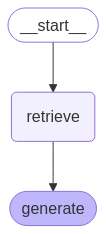

In [15]:
"""LangGraph还附带了用于可视化应用程序控制流的内置工具。"""

from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

让我们来测试我们的应用程序吧！LangGraph支持多种调用模式，包括同步、异步和流式传输。

In [16]:
# invoke

result = graph.invoke({"question": "What is Task Decomposition?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(id='99a0929e-0a2c-4bd5-8d4b-9dd64c313d9e', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2192}, page_content='Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a classifier (via a prompt) or majority vote.\nTask decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.'), Document(id='a2ad99e3-6325-4c77-9892-0680365dbe0a', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Tree of Thoughts (Yao et al. 2023

In [17]:
# Stream steps

for step in graph.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")

{'retrieve': {'context': [Document(id='99a0929e-0a2c-4bd5-8d4b-9dd64c313d9e', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2192}, page_content='Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a classifier (via a prompt) or majority vote.\nTask decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.'), Document(id='a2ad99e3-6325-4c77-9892-0680365dbe0a', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Tree of Thoughts 

In [18]:
# Stream tokens

for message, metadata in graph.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="messages"
):
    print(message.content, end="|")

Task| Decom|position| is| the| process| of| breaking| down| complex| tasks| into| more| manageable| sub|-t|asks| or| steps|.| This| can| be| achieved| through| various| methods| including| prompting| an| L|LM| (|like| "|Steps| for| XYZ|"),| using| task|-specific| instructions| (|like| writing| a| story| outline|),| or| with| human| input|.| When| it| comes| to| Task| Execution|,| expert| models| are| utilized| to| carry| out| these| individual| tasks| and| log| the| results|.

|To| illustrate| this| process| step|-by|-step|:
|1|)| **|User| Input|:**| The| user| asks| to| solve| a| complex| problem|.
|2|)| **|Task| Planning|:**| This| involves| devis|ing| multiple| potential| ways| of| approaching| the| task| at| each| step| using| thought| decomposition|.| Tasks| are| divided| into| separate|,| more| straightforward| parts| (|like| components| or| steps| required|).
|3|)| **|Model| Selection|:**| Depending| on| the| nature| of| the| tasks| and| goals| set| out| in| Task| Planning|,| va

In [19]:
"""如上所示，我们可以从prompt hub加载提示（例如，这个RAG提示）。提示也可以很容易地进行自定义。例如："""

from langchain_core.prompts import PromptTemplate

template = """Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Use three sentences maximum and keep the answer as concise as possible.
Always say "thanks for asking!" at the end of the answer.

{context}

Question: {question}

Helpful Answer:"""
custom_rag_prompt = PromptTemplate.from_template(template)

查询分析  
到目前为止，我们是使用原始输入查询来执行检索的。然而，允许模型为检索目的生成查询有一些优势。例如：  
  
除了语义搜索之外，我们还可以构建结构化的过滤器（例如，“查找2020年以来的文档”）；  
模型可以重写用户的查询，这些查询可能是多方面的或包含不相关的语言，从而生成更有效的搜索查询。  
  
查询分析利用模型从原始用户输入中转换或构建优化的搜索查询。我们可以轻松地将查询分析步骤整合到我们的应用程序中。为了说明这一点，让我们向向量存储中的文档添加一些元数据。我们将添加一些（人为的）部分到文档中，以便日后可以根据这些部分进行过滤。  

In [20]:
total_documents = len(all_splits)
third = total_documents // 3

for i, document in enumerate(all_splits):
    if i < third:
        document.metadata["section"] = "beginning"
    elif i < 2 * third:
        document.metadata["section"] = "middle"
    else:
        document.metadata["section"] = "end"


all_splits[0].metadata

{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
 'start_index': 8,
 'section': 'beginning'}

我们需要更新向量存储中的文档。为此，我们将使用一个简单的InMemoryVectorStore，因为我们将利用它的一些特定功能（例如元数据过滤）。  
有关您所选择的向量存储的相关特性，请参阅向量存储集成文档。  

In [21]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)
_ = vector_store.add_documents(all_splits)

接下来，让我们为我们的搜索查询定义一个模式。我们将使用结构化输出来实现这一目的。这里我们定义一个查询包含一个字符串查询和一个文档部分（可以是“beginning”、“middle”或“end”），但你可以根据需要自行定义。

In [22]:
from typing import Literal

from typing_extensions import Annotated


class Search(TypedDict):
    """Search query."""

    query: Annotated[str, ..., "Search query to run."]
    section: Annotated[
        Literal["beginning", "middle", "end"],
        ...,
        "Section to query.",
    ]

最后，我们在LangGraph应用程序中添加一个步骤，以便从用户的原始输入生成查询：

In [23]:
class State(TypedDict):
    question: str
    query: Search
    context: List[Document]
    answer: str


def analyze_query(state: State):
    structured_llm = llm.with_structured_output(Search)
    query = structured_llm.invoke(state["question"])
    return {"query": query}


def retrieve(state: State):
    query = state["query"]
    retrieved_docs = vector_store.similarity_search(
        query["query"],
        filter=lambda doc: doc.metadata.get("section") == query["section"],
    )
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate])
graph_builder.add_edge(START, "analyze_query")
graph = graph_builder.compile()

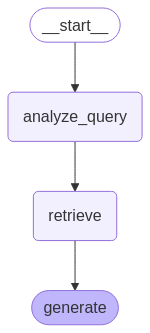

In [24]:
display(Image(graph.get_graph().draw_mermaid_png()))

我们可以通过专门要求提供帖子末尾的上下文来测试我们的实现。请注意，模型在其回答中包含了不同的信息。

In [25]:
for step in graph.stream(
    {"question": "What does the end of the post say about Task Decomposition?"},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")

{'analyze_query': {'query': {'query': 'What does the end of the post say about Task Decomposition?', 'section': 'end'}}}

----------------

{'retrieve': {'context': [Document(id='b2b729af-a84b-4b06-9a42-73c12935b296', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 39220, 'section': 'end'}, page_content='Finite context length: The restricted context capacity limits the inclusion of historical information, detailed instructions, API call context, and responses. The design of the system has to work with this limited communication bandwidth, while mechanisms like self-reflection to learn from past mistakes would benefit a lot from long or infinite context windows. Although vector stores and retrieval can provide access to a larger knowledge pool, their representation power is not as powerful as full attention.\n\n\nChallenges in long-term planning and task decomposition: Planning over a lengthy history and effectively exploring the solution space